In [37]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [38]:
mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)

In [7]:
buffer_size = 70000
batch_size = 128
num_epochs = 20

In [8]:
mnist_train,mnist_test = mnist_dataset['train'],mnist_dataset['test']

In [9]:
def scaler(image,label):
    image = tf.cast(image,tf.float32)
    image /= 255.
    return image,label

In [10]:
scaled_train_val = mnist_train.map(scaler)
scaled_test = mnist_test.map(scaler)

In [12]:
num_val_samples = 0.1 * mnist_info.splits['train'].num_examples
num_val_samples = tf.cast(num_val_samples,tf.int64)
num_test_samples = mnist_info.splits['test'].num_examples
num_test_samples = tf.cast(num_test_samples,tf.int64)

In [13]:
shuffled_train = scaled_train_val.shuffle(buffer_size)
validation_data = scaled_train_val.take(num_val_samples)
train_data = scaled_train_val.skip(num_val_samples)
train_data = train_data.batch(batch_size)
validation_data = validation_data.batch(num_val_samples)

In [25]:
test_data = scaled_test.batch(num_test_samples)

In [18]:
con_model = tf.keras.Sequential([
                                 tf.keras.layers.Conv2D(50,5,activation='relu',input_shape=(28,28,1)),
                                 tf.keras.layers.MaxPooling2D(),
                                 tf.keras.layers.Conv2D(50,3,activation='relu'),
                                 tf.keras.layers.MaxPooling2D(),
                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(10)
                                ])

In [19]:
con_model.summary(line_length=75)

Model: "sequential_1"
___________________________________________________________________________
 Layer (type)                    Output Shape                  Param #     
 conv2d_2 (Conv2D)               (None, 24, 24, 50)            1300        
                                                                           
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 50)            0           
                                                                           
 conv2d_3 (Conv2D)               (None, 10, 10, 50)            22550       
                                                                           
 max_pooling2d_3 (MaxPooling2D)  (None, 5, 5, 50)              0           
                                                                           
 flatten_1 (Flatten)             (None, 1250)                  0           
                                                                           
 dense_1 (Dense)                 (None, 10)                    125

In [20]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [21]:
con_model.compile(optimizer='adam',loss=loss,metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='auto',min_delta=0,patience = 2,verbose=0,restore_best_weights=True)

In [22]:
con_model.fit(train_data,
          epochs = num_epochs,
          validation_data = validation_data,
          verbose = 2,
          callbacks = [early_stopping]
         )

Epoch 1/20
422/422 - 43s - loss: 0.2655 - accuracy: 0.9240 - val_loss: 0.0935 - val_accuracy: 0.9743 - 43s/epoch - 101ms/step
Epoch 2/20
422/422 - 31s - loss: 0.0693 - accuracy: 0.9791 - val_loss: 0.0664 - val_accuracy: 0.9808 - 31s/epoch - 74ms/step
Epoch 3/20
422/422 - 36s - loss: 0.0501 - accuracy: 0.9845 - val_loss: 0.0582 - val_accuracy: 0.9828 - 36s/epoch - 85ms/step
Epoch 4/20
422/422 - 38s - loss: 0.0397 - accuracy: 0.9880 - val_loss: 0.0541 - val_accuracy: 0.9838 - 38s/epoch - 91ms/step
Epoch 5/20
422/422 - 31s - loss: 0.0330 - accuracy: 0.9902 - val_loss: 0.0536 - val_accuracy: 0.9852 - 31s/epoch - 75ms/step
Epoch 6/20
422/422 - 29s - loss: 0.0278 - accuracy: 0.9917 - val_loss: 0.0532 - val_accuracy: 0.9858 - 29s/epoch - 69ms/step
Epoch 7/20
422/422 - 34s - loss: 0.0236 - accuracy: 0.9932 - val_loss: 0.0521 - val_accuracy: 0.9857 - 34s/epoch - 81ms/step
Epoch 8/20
422/422 - 35s - loss: 0.0204 - accuracy: 0.9940 - val_loss: 0.0525 - val_accuracy: 0.9862 - 35s/epoch - 83ms/step

In [26]:
test_loss,test_accuracy = con_model.evaluate(test_data)
print(f"Loss = {round(test_loss,2)} , accuracy = {round(test_accuracy*100,2)} %")

1/1 [==============================] - 2s 2s/step - loss: 0.0401 - accuracy: 0.9878
Loss = 0.04 , accuracy = 98.78 %


In [27]:
import numpy as np
import matplotlib.pyplot as plt

In [28]:
# Split the test_data into 2 arrays, containing the images and the corresponding labels
for images, labels in test_data.take(1):
    images_test = images.numpy()
    labels_test = labels.numpy()

# Reshape the images into 28x28 form, suitable for matplotlib (original dimensions: 28x28x1)
images_plot = np.reshape(images_test, (10000,28,28))

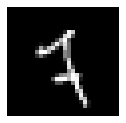

Label: 7


In [35]:
# The image to be displayed and tested
i = 34


# Plot the image
plt.figure(figsize=(2, 2))
plt.axis('off')
plt.imshow(images_plot[i-1], cmap="gray", aspect='auto')
plt.show()

# Print the correct label for the image
print("Label: {}".format(labels_test[i-1]))

<BarContainer object of 10 artists>

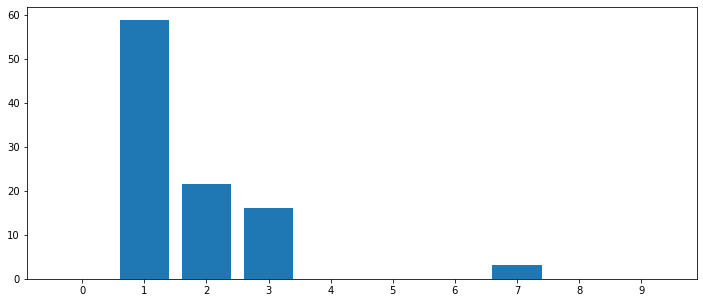

In [36]:
# Obtain the model's predictions (logits)
predictions = con_model.predict(images_test[i-1:i])

# Convert those predictions into probabilities (recall that we incorporated the softmaxt activation into the loss function)
probabilities = tf.nn.softmax(predictions).numpy()
# Convert the probabilities into percentages
probabilities = probabilities*100


# Create a bar chart to plot the probabilities for each class
plt.figure(figsize=(12,5))
plt.bar(x=[1,2,3,4,5,6,7,8,9,10], height=probabilities[0], tick_label=["0","1","2","3","4","5","6","7","8","9"])